## Chapter 11

### Gradient 소실, 폭주

* 출력층으로 오차 gradient를 전파하면서 진행되고, 알고리즘이 신경망의 모든 파라미터에 대한 오차 함수의 gradient(기울기)를 계산하면 경사 하강법 단계에서 gradient를 사용해 각 파라미터를 수정함.
* 그러나, 알고리즘이 하위 층으로 진행될수록 gradient가 점점 작아지게 되고, 이러한 가중치를 변경되지 않은 채로 둔다면 좋은 솔루션으로 수렴되지 않게 됨. 이를 그레이디언트 소실(vanishing gradient)라고 함.
* 또한, 그레이디언트가 점점 커져 여러 층이 비정상적으로 큰 가중치로 갱신되면 알고리즘이 발산(diverse)하는데 이를 그레이디언트 폭주(exploding gradient)라고 함.
  * 불안정한 gradient는 층마다 학습 속도를 달라지게 만들기 때문에 심층 신경망 훈련을 어렵게 함.
  * sigmoid 활성화 함수와, 정규분포를 기반으로 한 가중치 초기화 방법으로 인해 각 층에서 출력의 분산이 입력의 분산보다 크다는 게 밝혀져, 신경망의 위쪽으로 갈수록 분산이 계속 커져 결국에는 가장 높은 층에서 활성화 함수가 0이나 1로 수렴해버림.

* gradient 문제를 해결하기 위해서는 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 하고, 역방향에서 층을 통과하기 전과 후의 gradient 분산이 동일해야 한다는 주장이 많음.
  * 층의 입력과 출력 개수는 각각 층의 fan-in, fan-out이라고 함.
* 이를 위해, 각 층의 연결 가중치를 아래의 방식대로 무작위로 초기화하는 데, 이를 Xavier 초기화(또는 Glorot 초기화)라고 함.
$$ \text{평균이 0이고 분산이}\;\sigma^2=\frac{1}{fan_{\text{avg}}}\;인\;정규분포$$
$$또는\;r=\sqrt{\frac{3}{fan_{\text{avg}}}}일\;때, -r과\;+r사이의\;균등분포$$
$$(fan_{\text{avg}}=(\text{fan-in}+\text{fan-out})/2)

  * $fan_{\text{avg}}$를 $fan_{\text{in}}$으로 바꾸면 LuCun 초기화.
* 위의 초기화 방식을 사용하면 훈련 속도가 상당히 높아짐.
* 각 활성화 함수에 대한 초기화 전략은 위의 식에서 분산의 스케일링이나 fan_avg, fan_in중 어떤 것을 쓰느냐만 다름. 특별히 ReLU활성화 함수에 대한 초기화 방법은 He 초기화라고 함.

|초기화 전략|활성화 함수|$\sigma^2$(정규분포)|
|----------|----------|--------------------|
|Glorot    |tanh, softmax, sigmoid, 활성화 함수 없음|1/$fan_{\text{avg}}$|
|He        |ReLU      |2/$fan_{\text{in}}$|
|LuCun     |SELU      |1/$fan_{\text{in}}$|


* Keras에서는 기본적으로 균등분포의 Glorot 초기화를 사용.
* 다른 초기화를 사용하려면 층을 만들 때 <code>kernel_initalizer</code> 하이퍼파라미터를 사용

In [4]:
import tensorflow as tf
from tensorflow import keras

d:\pythonenv\mlenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\pythonenv\mlenv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
d:\pythonenv\mlenv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [6]:
# He 초기화 사용
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")
keras.layers.Dense(10, activation="relu", kernel_initializer="he_uniform")

# fan_in 대신 fan_avg기반의 균등분포 He 초기화(VarianceScaling 사용)
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode="fan_avg", distribution="uniform")
keras.layers.Dense(10, activation="sigmoid", kernel_initializer=he_avg_init)

> * <code>VarianceScaling</code>의 매개변수 기본값 : scale=1.0, mode='fan_in', distribution='truncated_normal'.
>   * distribution='truncated_normal' : 절단 정규분포. $\sigma^2=1.3*scale/mode$ 
>   * distribution='untruncated_normal' : 정규분포. $\sigma^2=scale/mode$
> * kernel_initializer의 기본값은 'glorot_uniform'으로, <code>VarianceScaling(scale=1.0, mode='fan_avg', distribution='uniform')</code>과 동일.
>   * 'he_normal'은 <code>VarianceScaling(scale=2., mode='fan_in', distribution='truncated_normal')</code>
>   * 'lecun_normal'은 VarianceScaling의 기본값 사용.

* 활성화 함수를 잘못 선택하면 gradient 소실이나 폭주로 이어질 수 있음.
* ReLU는 특정 양수값에 수렴하지 않는다는 장점이 있지만 ReLU는 완벽하지 않음.
  * 훈련하는 동안 일부 뉴런이 0이외의 값을 출력하지 않게 되는 죽은 ReLU(dying ReLU)문제가 있음.
  * 학습률이 크면 뉴런 절반이 죽어 있기도 함.
  * 뉴런의 가중치가 바뀌어 훈련 세트의 모든 샘플에 대한 입력 가중치 합이 음수가 되면 뉴런이 죽게 됨. 가중치 합이 음수이면 ReLU의 gradient가 0이 되어 경사 하강법이 작동하지 않게 됨.
* 이를 해결하기 위해 ReakyReLU라는 ReLU함수의 변종을 사용
  * $\text{LeakyReLU}_{\alpha}(z)=\text{max}(\alpha z, z)$
  * $\alpha$ : 함수가 새는(leaku) 정도. 즉, z<0일때의 함수의 기울기. 일반적으로 0.01로 설정함.
  * $\alpha$ 덕분에 뉴런이 죽지 않게 만들어줌.
  * ReLU보다 LeakyReLU가 항상 성능이 높음.
  * RReLU(randomized leaky ReLU) : 훈련 시에는 $\alpha$를 주어진 범위에서 무작위로 선택하고, 테스트 시에는 평균을 사용. 훈련 세트의 과대적합을 줄이는 규제의 역할을 하는 것 처럼 작동.
  * PReLU(parametric leaky ReLU) : $\alpha$가 훈련하는 동안에 학습됨. 대규모 이미지 데이터셋에서는 성능이 좋지만, 소규모 데이터셋에서는 과대적합될 가능성이 높음.
* ELU(exponential linear unit) : 훈련 시간이 줄고 신경망의 테스트 세트 성능도 더 높은 함수.
$ \text{ELU}_{\alpha}(z)=\begin{cases}
\alpha(\exp(z)-1), & if\;z<0 \\
z, & if\;z\geq0
\end{cases}$
  * ReLU와 거의 비슷
  * z<0때 음수값이 들어오므로 활성화 함수의 평균 출력이 0에 가까워짐. 그레이디언트 소실 문제를 완화해줌.
  * $\alpha$는 z가 큰 음수값일 떄 ELU가 수렴할 값을 정의. 주로 1로 설정하지만 변경 가능.
  * z<0 일 때도 gradient가 0이 아니므로 죽은 뉴런을 만들지 않음.
  * $\alpha$=1이면 z=0에서 급격히 변동하지 않으므로 모든 구간에서 매끄럽기 때문에 경사 하강법의 속도를 높여줌.
  * 단, ReLU와 다른 변종들보다 계산 속도가 느림.
* SELU(Scaled ELU) : 스케일이 조정된 ELU함수의 변종.
$ \text{selu}(z)=\lambda\cdot\text{ELU}_{\alpha}(z)$
  * 완전 연결 층만 쌓고, 모든 은닉층을 SELU활성화 함수를 사용하도록 하면 네트워크가 자기 정규화됨. (훈련하는 동안 각 층의 출력이 평균은 0, 표준편차는 1을 유지하는 경향이 있음). 이는 gradient 소실과 폭주 문제를 막아줌.
  * 단, 입력 특성이 반드시 표준화되어야 하고(평균은 0, 표준편차는 1) 모든 은닉층의 가중치는 Lecun 정규분포 초기화로 초기화되어야 함(<code>kernel_initializer="lecun_normal"</code>). 또한, 네트워크는 일렬로 쌓은 층으로 구성되어야 하며 순환 신경망이나 스킵 연결(건너뛰어 연결된 층)과 같은 비 순차적 구조에는 사용하는 것이 힘듦.
> 단, 일부의 경우 CNN에서도 SELU 사용 시 성능을 향상시킬 수도 있음.
* 심층 신경망 은닉층에 사용할 활성화함수는 일반적으로 SELU > ELU > LeakyReLU(와 그 변종들) > ReLU > tanh > sigmoid 순으로 사용. 만약, 네트워크가 자기 정규화되지 못하면 ELU가 더 나을 수도 있고, 실행 속도가 중요하면 LeakyReLU가 더 좋을 수도 있음. 신경망이 과대적합되었다면 RReLU, 훈련세트가 아주 크다면 PReLU를 사용할 수 있음. 일반적으로는 ReLU가 가장 널리 사용되어왔으므로 대부분의 라이브러리와 하드웨어는 ReLU에 특화되어 있음. 즉, 속도가 중요하면 ReLU가 가장 좋은 선택.

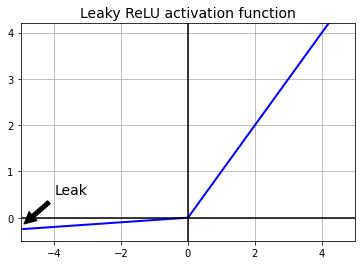

In [9]:
import matplotlib.pyplot as plt
import numpy as np

z = np.linspace(-5, 5, 200)

# LeakyReLU

def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

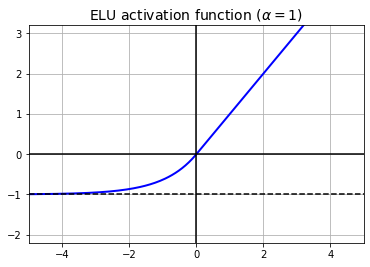

In [11]:
# ELU
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

* LeakyReLU를 사용하려면 LeakyReLU층을 만들고, 모델에서 적용하려는 층 뒤에 추가함.

In [12]:
model = keras.models.Sequential([
    # ...
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.2)
    # ...
])

* PReLU를 사용하려면 <code>LeakyReLU</code> 부분을 PReLU로 바꿈. Keras에서는 공식적인 구현은 없음.

* SELU를 사용하려면 층을 만들 때 <code>activation="selu", kernel_initalizer="lecun_normal"</code> 지정.

In [13]:
layer = keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")

* ELU나 다른 ReLU 변종과 함께 He 초기화를 사용하면 훈련 초기화 단계에서는 gradient문제를 감소시킬 수 있음.
* 하지만, 훈련하는 동안 다시 발생하지 않으리라는 보장은 없음.
* 이를 위해 배치 정규화(Batch normalization) 방법 사용.
  * 각 층에서 활성화 함수를 통과하기 전이나 후에 연산을 하나 추가함.
  * 입력을 원점에 맞추고 정규화한 뒤, 각 층에서 두 개의 새로운 파라미터로 결과값의 스케일을 조절하고 이동시킴. 한 파라미터는 스케일 조정에, 나머지 하나는 이동에 사용함.
* 신경망의 첫 번째 층으로 배치 정규화를 추가하면 훈련 세트를 StandardScaler 등을 사용해 표준화할 필요가 없음.
* 입력 데이터를 원점에 맞추고 정규화하기 위해 평균과 표준편차를 추정해야 함. 이를 위해 현재 미니배치에서 입력의 평균과 표준편차를 평가함.
$$ \boldsymbol{\mu}_B=\frac{1}{m_B}\sum_{i=1}^{m_B}\mathbf{X}^{(i)} $$
$$ \boldsymbol{\sigma}_B^2=\frac{1}{m_B}\sum_{i=1}^{m_B}\left(\mathbf{x}^{(i)}-\boldsymbol{\mu}_B\right)^2 $$
$$ \hat{\mathbf{x}}^{(i)}=\frac{\mathbf{x}^{(i)}-\boldsymbol{\mu}_B}{\sqrt{\boldsymbol{\sigma}_B^2+\epsilon}} $$
$$ \mathbf{z}^{(i)}=\gamma\otimes\hat{\mathbf{x}}^{(i)}+\boldsymbol{\beta} $$
  * $\boldsymbol{\mu}_B$ : 미니배치 B에 대한 입력의 평균 벡터
  * $\boldsymbol{\sigma}_B$ : 미니배치에 대한 입력의 표준편차 벡터
  * $ m_B$ : 미니배치 내의 샘플 수
  * $\hat{\mathbf{x}}^{(i)}$ : 평균이 0이고 정규화된 샘플 i의 입력
  * $\gamma$ : 층의 출력 스케일 파라미터 벡터. $\gamma$와 $\boldsymbol{\beta}$의 차원은 모두 $\mathbf{z}^{(i)}$와 동일. (각 층의 뉴런마다 $\gamma$와 $\boldsymbol{\beta}$를 가진다는 의미.)
  * $\otimes$ : 원소별 곱셈
  * $\boldsymbol{\beta}$ : 층의 출력 이동 파라미터 벡터. 각 입력은 해당 파라미터만큼 이동
  * $\epsilon$ : 분모가 0이 되는 것을 막기 위한 작은 숫자. 안전을 위한 항(smoothing term)이라고 함. 주로 10^-5.
  * $\mathbf{z}^{(i)}$ : 배치 정규화 연산의 출력. 즉, 입력의 스케일을 조정하고 이동시킨 것.